# Continuous Scan in azimuth 
Code by JCH

Data taken :
- on 2019-02-22
- on 2019-03-05 only to calibrate the azimuth rotation. 

In [156]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(10,7))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string

Get the directories corresponding to the day we consider:

In [157]:
day = '2019-02-22'
data_dir = '/qubic/Data/Calib-TD/'+day+'/'
dirs = glob.glob(data_dir+'/*')
dirs

['/qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2',
 '/qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.11.38__Scan1']

In [158]:
labels = []
for d in dirs:
    bla = str.split(d,'__')
    print bla
    labels.append(bla[1])
labels

['/qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01', 'Scan2']
['/qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.11.38', 'Scan1']


['Scan2', 'Scan1']

## Time synchronisation
We first look at pixel 63 in ASIC2 in first dataset (Source_scan1). Same pixel as Michel did on QubicStudio,  read the Azimuth and put both times starting at zero.

In [159]:
thedir = dirs[0]
a = qp()
a.read_qubicstudio_dataset(thedir, asic=2)
nsamples = len(a.timeline(TES=63))
pow2 = int(np.log(nsamples) / np.log(2))
ns = 2**pow2
FREQ_SAMPLING = 1. / a.sample_period()

t_data = a.timeline_timeaxis(axistype='pps')
#t_data = a.timeline_timeaxis(axistype='index')

# Put the data time origine at 0
mini_t_data = np.min(t_data)
t_data -= mini_t_data

Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic2-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic2-2019.02.22.162801.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/conf-asics-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/

In [ ]:
# print(told)
# print(tnew-tnew[0])
# TESnum = 63
# data = a.timeline(TES=TESnum)
# plot(told, data, alpha=0.5)
# plot(tnew-np.min(tnew)-122, data, alpha=0.5)

## Time and Azimuth angle
Read the data hkintern and convert the azimuth angle from encoder steps to degrees.

In [162]:
t_az, azinit = ft.read_hkintern(thedir, thefieldname='Platform-Azimut')
az = (azinit - 2.**15) / 2.**16 * 360
t_az -= mini_t_data

print(np.min(azinit), np.max(azinit))
print(np.min(az), np.max(az))
print(azinit)
print(np.min(t_az), np.max(t_az))
print(t_data)
print(np.unique(az))


(30306, 35383)
(-13.524169921875, 14.3646240234375)
[32856 32856 32856 ... 30787 30787 30788]
(-1.2243590354919434, 5119.775640964508)
[0.00000000e+00 6.41012192e-03 1.28204823e-02 ... 5.11899500e+03
 5.11900145e+03 5.11900790e+03]
[-13.52416992 -13.51867676 -13.51318359 ...  14.3536377   14.35913086
  14.36462402]


## Calibration of the number of motor steps per degree

In [160]:
angle_given = 10.
angle_measured = np.max(az) - np.min(az)
print(angle_given, angle_measured)

nb_encoder_step_per_degree = (np.max(azinit) - np.min(azinit)) / angle_measured
print(nb_encoder_step_per_degree)

nb_motor_step_per_degree = 168830
nb_motor_step_per_degree_new = nb_motor_step_per_degree / (angle_measured / angle_given)
print (nb_motor_step_per_degree_new)

(10.0, 0.0054931640625)
182.04444444444445
307345635.5555556


## Look at the data

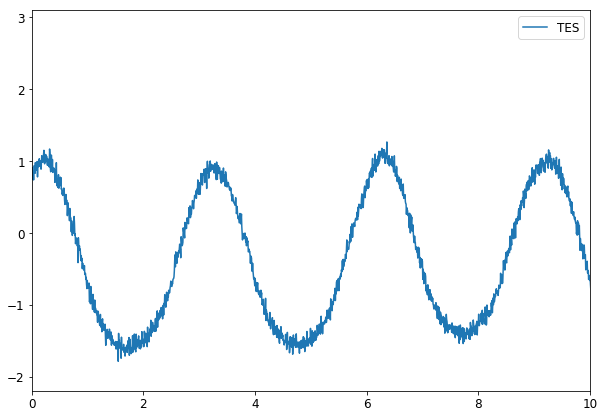

In [149]:
TESnum = 63
data = a.timeline(TES=TESnum)

plot(t_data, (data - np.mean(data)) / np.std(data), label='TES')
# plot(t_az - np.min(t_az), (az - np.mean(az)) / np.std(az), label='Az')
legend()


thedata = data - f.gaussian_filter1d(data, 1000)

Text(0,0.5,'Data')

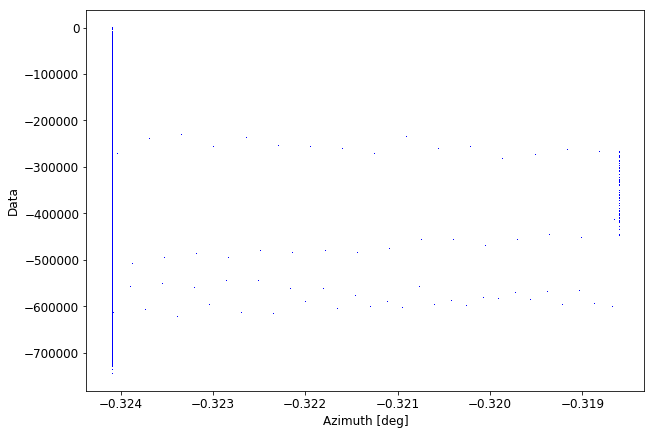

In [152]:
new_az = np.interp(t_data, t_az-min(t_az), az)
plot(new_az, data,'b,')
xlabel('Azimuth [deg]')
ylabel('Data')

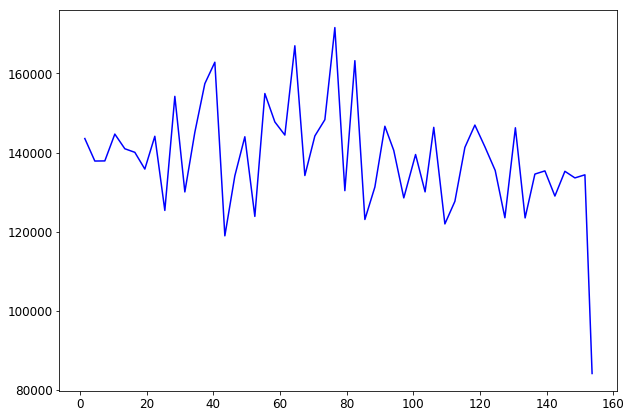

In [153]:
ppp = 3.
period = ppp * (t_data / int(ppp)).astype(int)
allperiods = np.unique(period)
tper = np.zeros(len(allperiods))
azper = np.zeros(len(allperiods))
ampdata = np.zeros(len(allperiods))
for i in xrange(len(allperiods)):
    ok = (period == allperiods[i])
    azper[i] = np.mean(new_az[ok])
    tper[i] = np.mean(t_data[ok])
    ampdata[i] = np.std(data[ok])
plot(tper, ampdata, 'b')

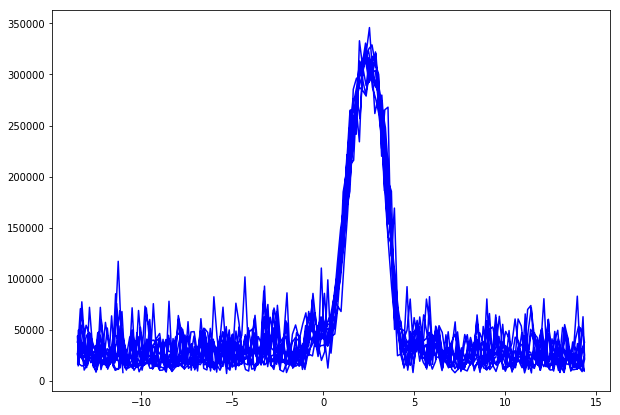

In [13]:
plot(azper, ampdata, 'b')

In [154]:
nbins = 150
azfinalbins = min(azper) + (max(azper) - min(azper)) * np.linspace(0, 1, nbins+1)
azfinal = np.zeros(nbins)
ampfinal = np.zeros(nbins)
err_ampfinal = np.zeros(nbins)
for i in xrange(nbins):
    ok = (azper >= azfinalbins[i]) & (azper < azfinalbins[i+1])
    azfinal[i] = 0.5 * (azfinalbins[i] + azfinalbins[i+1])
    ampfinal[i] = np.mean(ampdata[ok])
    err_ampfinal[i] = np.std(ampdata[ok]) / np.sqrt(ok.sum())

def gauss(x,par):
    return par[3]+par[2]*np.exp(-0.5 * (x-par[0])**2 / par[1]**2)

thecut = 350000
okfit = (ampfinal < thecut) & (err_ampfinal != 0)
print(okfit.sum())
guess = np.array([3., 2., np.max(ampfinal)-np.min(ampfinal), np.min(ampfinal)])
res = ft.do_minuit(azfinal[okfit], ampfinal[okfit], err_ampfinal[okfit], guess, functname=gauss, verbose=False)

rc('figure',figsize=(12,7))

subplot(1,2,1)
plot(azfinal, ampfinal,'b',label='Data')
plot(azfinal[okfit], ampfinal[okfit],'b.',label='Data for fit')
plot(azfinal, gauss(azfinal, res[1]), 'r', label='Fit: FWHM={0:4.2f} deg'.format(res[1][1]*2.35))
plot(azfinal, azfinal*0+thecut, 'k:',label='Cut for fit')
xlabel('Azimuth')
ylabel('Beam')
title('TES #{}'.format(TESnum))
legend(fontsize=9)

ampfinaldB = 10 * np.log10(np.abs((ampfinal-res[1][3])/res[1][2]))
subplot(1,2,2)
plot(azfinal, ampfinaldB,'b')
plot(azfinal[okfit], ampfinaldB[okfit],'b.')
plot(azfinal, 10*np.log10((gauss(azfinal, res[1])-res[1][3])/res[1][2]), 'r', label='Fit')
xlabel('Azimuth')
ylabel('Beam [dB]')
title('TES #{}'.format(TESnum))
ylim(-25,0)
tight_layout()

1


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:83: Runtime

FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,nan,nan,0.000000e+00,0.000000e+00,,,
2,c1,nan,nan,0.000000e+00,0.000000e+00,,,
3,c2,nan,nan,0.000000e+00,0.000000e+00,,,
4,c3,nan,nan,0.000000e+00,0.000000e+00,,,


fibtools.py:204: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = +nan
    c1 = +nan
    c2 = +nan
    c3 = +nan

  m.hesse()
fibtools.py:204: HesseFailedWarning: HESSE Failed. Covariance and GlobalCC will not be available
  m.hesse()


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,nan,nan,0.000000e+00,0.000000e+00,,,
2,c1,nan,nan,0.000000e+00,0.000000e+00,,,
3,c2,nan,nan,0.000000e+00,0.000000e+00,,,
4,c3,nan,nan,0.000000e+00,0.000000e+00,,,


RuntimeError: Covariance is not valid. May be the last Hesse call failed?

['/qubic/Data/Calib-TD/calsource/calsource_20190222T150113.dat'
 '/qubic/Data/Calib-TD/calsource/calsource_20190222T161710.dat'
 '/qubic/Data/Calib-TD/calsource/calsource_20190222T164144.dat']


(-1, 1)

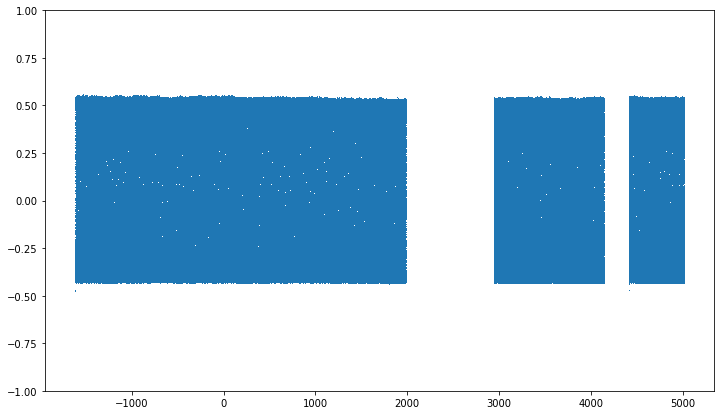

In [18]:
fcalsrc = np.sort(glob.glob('/qubic/Data/Calib-TD/calsource/calsource_20190222*'))
print fcalsrc
tt = []
dd = []
for ff in fcalsrc:
    thett, thedd = np.loadtxt(ff).T
    tt.append(thett)
    dd.append(thedd)

tt = np.concatenate(tt)
dd = np.concatenate(dd)
tt += 3600 - mini_t_data
dd = (dd-np.mean(dd)) / np.std(dd)
plot(tt, dd, ',')
ylim(-1,1)

(4790, 4800)

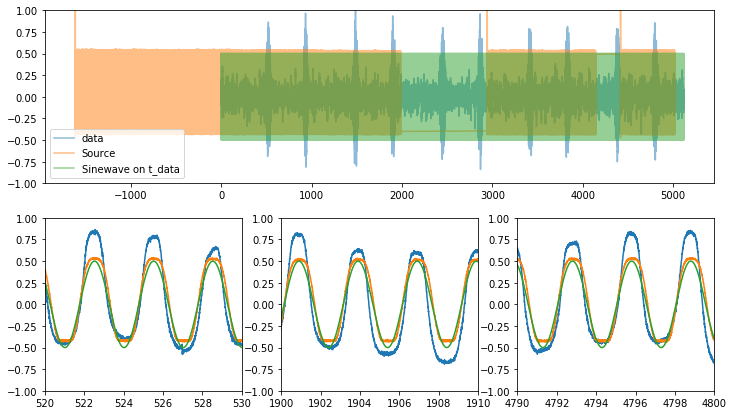

In [19]:

fct = np.sin((t_data+0.75)*2*np.pi/(1./0.333))/2

shift = -0.45
subplot(2,1,1)
plot(t_data, thedata/np.max(thedata), alpha=0.5, label='data')
plot(tt-np.min(t_az)-shift, dd, alpha=0.5, label='Source')
plot(t_data, fct, alpha=0.5, label='Sinewave on t_data')
ylim(-1,1)
legend(loc='lower left')

subplot(2,3,4)
plot(t_data, thedata/np.max(thedata))
plot(tt-np.min(t_az)-shift, dd)
plot(t_data, fct)
ylim(-1,1)
xlim(520,530)

subplot(2,3,5)
plot(t_data, thedata/np.max(thedata))
plot(tt-np.min(t_az)-shift, dd)
plot(t_data, fct)
ylim(-1,1)
xlim(1900,1910)

subplot(2,3,6)
plot(t_data, thedata/np.max(thedata))
plot(tt-np.min(t_az)-shift, dd)
plot(t_data, fct)
ylim(-1,1)
xlim(4790,4800)
